In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline
gen = lambda : torch.Generator().manual_seed(2147483647)

In [2]:
words = open('names.txt', 'r').read().splitlines()
dataset_size = len(words)
print(f'{dataset_size=}')
words[:8]

dataset_size=32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build vocabulary of characters and mapping to/from integers
special_character = '.'
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)} # string to int
stoi[special_character] = 0
itos = {i: s for s, i in stoi.items()} # int to string
V = len(stoi)

In [ ]:
# build dataset
block_size = 3
def build_dataset(words: list[str], block_size: int = 3):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + special_character:
            idx = stoi[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    
    X, y = torch.tensor(X), torch.tensor(y)
    print(f'{X.shape=}, {y.shape=}')
    return X, y

random.seed(42)
random.shuffle(words)
n1 = int(dataset_size*.8)
n2 = int(dataset_size*.9)
X_train, y_train = build_dataset(words[:n1])    # 80%
X_dev, y_dev = build_dataset(words[n1:n2])      # 10%
X_test, y_test = build_dataset(words[n2:])      # 10%

X.shape=torch.Size([182625, 3]), y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 3]), y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 3]), y.shape=torch.Size([22866])


## Initialize the model

In [ ]:
# implementing the hidden layer
g = gen() # for reproducibility
h_neurons = 300
embedding_size = 10
sample_size = X_train.shape[0]

# initial random embeddings
C = torch.randn((V,embedding_size),                         generator=g)

# look up the embeddings for the training data
emb = C[X_train]

# initialise the learnable parameters of the first layer of neurons
W1 = torch.randn((block_size*embedding_size, h_neurons),    generator=g) / (5/3) * (block_size * embedding_size) ** .5 # Kaiming initialization
# b1 = torch.randn(h_neurons,                                 generator=g)* 0.01
batch_norm_gain = torch.ones((1,h_neurons))
batch_norm_bias = torch.zeros((1,h_neurons))
batch_norm_running_mean = torch.zeros(h_neurons)
batch_norm_running_std = torch.zeros(h_neurons)
# flatten the embeddings to concatenate the vector for each input character giving us a n x (embedding size x block size) matrix
emb_reshaped = emb.view((sample_size, block_size*embedding_size))

# apply activation function
h = torch.tanh(emb_reshaped @ W1)

# start implementing the output layer by randomly initializing the learnable parameters
W2 = torch.randn((h_neurons, V),                            generator=g) / h_neurons ** .5
b2 = torch.randn(V,                                         generator=g) * 0.01
logits = h @ W2 + b2
print(f'{h.std()=} {logits.std()=} {(block_size * embedding_size) ** .5=}')

loss = F.cross_entropy(logits, y_train)
parameters = [C, W1,  W2, b2, batch_norm_gain, batch_norm_bias]
parameter_count = sum([p.nelement() for p in parameters])
print(f'{parameter_count=}')
for p in parameters:
    p.requires_grad = True
    
# initialise tracking datasets
lru = []
losses = []
loss

h.std()=tensor(0.9762) logits.std()=tensor(0.9890) (block_size * embedding_size) ** .5=5.477225575051661
parameter_count=18297


tensor(3.6826)

## Train the model

0 / 200000, loss = 3.2925987243652344
10 / 200000, loss = 3.520047187805176
20 / 200000, loss = 3.201998472213745
30 / 200000, loss = 3.1933441162109375
40 / 200000, loss = 3.282374620437622
50 / 200000, loss = 3.4623680114746094
60 / 200000, loss = 3.2719194889068604
70 / 200000, loss = 3.009429931640625
80 / 200000, loss = 3.2064223289489746
90 / 200000, loss = 3.294076681137085
100 / 200000, loss = 3.136150598526001
110 / 200000, loss = 2.887408494949341
120 / 200000, loss = 3.084998846054077
130 / 200000, loss = 3.3187005519866943
140 / 200000, loss = 3.2091758251190186
150 / 200000, loss = 3.0057318210601807
160 / 200000, loss = 2.937908172607422
170 / 200000, loss = 3.0076427459716797
180 / 200000, loss = 2.9626948833465576
190 / 200000, loss = 3.162799835205078
200 / 200000, loss = 2.7789053916931152
210 / 200000, loss = 2.9797494411468506
220 / 200000, loss = 2.827016830444336
230 / 200000, loss = 2.958024024963379
240 / 200000, loss = 2.822169542312622
250 / 200000, loss = 3.1

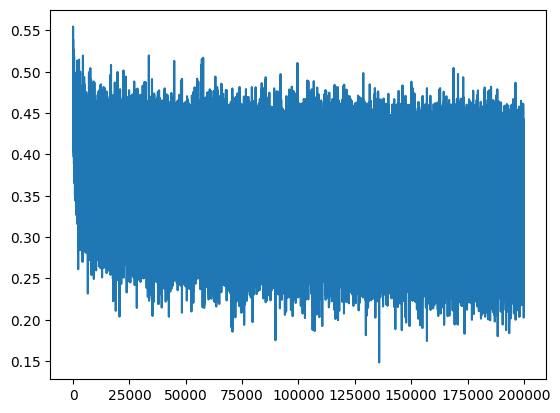

In [148]:
learning_rate = 0.01
iterations = 200_000
batch_size = 32
start = time.time()

lre = torch.linspace(-3, 0 ,iterations)
lrs = 10**lre

for i in range(iterations):
    mini_batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,),generator=g)
    # forward pass
    emb = C[X_train[mini_batch_indexes]]
    h_preactivation = emb.view(emb.shape[0], -1) @ W1
    batch_norm_mean_i = h_preactivation.mean(0, keepdim=True)
    batch_norm_std_i = h_preactivation.std(0, keepdim=True)
    h_preactivation = batch_norm_gain *  (h_preactivation - h_preactivation.mean(0, keepdim=True)) / h_preactivation.std(0, keepdim=True) + batch_norm_bias
    h = h_preactivation.tanh()
    
    with torch.no_grad():
        batch_norm_running_mean = .999 * batch_norm_running_mean + .001 * batch_norm_mean_i
        batch_norm_running_std = .999 * batch_norm_running_std + .001 * batch_norm_std_i
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[mini_batch_indexes])
    if i % 10 == 0:
        print(f'{i} / {iterations}, loss = {loss}')
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    for p in parameters:
        # p.data += -lrs[i] * p.grad
        p.data += -learning_rate * p.grad
        
    # track stats
    lru.append(lre[i])
    losses.append(loss.log10().item())
        
end = time.time()
length = end - start
print(f'Took {length:.{2}} seconds')

with torch.no_grad():
    emb = C[X_train]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactivation = emb_cat @ W1 
    batch_norm_mean = h_preactivation.mean(0, keepdim=True)
    batch_norm_std = h_preactivation.std(0, keepdim=True)
    
    
# Calculate training set loss
@torch.no_grad()
def get_split_loss(split: str):
    x,y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_test)
    }[split]
    
    emb = C[x] # dims -> (N, block_size, embedding_size)
    emb_reshaped = emb.view(emb.shape[0], block_size*embedding_size) # could also do (emb.shape[0], -1)
    h_preactivation = emb_reshaped @ W1
    h_preactivation = batch_norm_gain *  (h_preactivation - batch_norm_mean) / batch_norm_std + batch_norm_bias
    h = h_preactivation.tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split=}, {loss=}')
    
print(f'Last batch lost {loss=}')
get_split_loss('train') 
get_split_loss('dev') 
get_split_loss('test') 
plt.plot(range(len(losses)),losses)

In [149]:
batch_norm_mean

tensor([[ -3.0481,   2.3624,  -3.1419,  -1.2578, -11.9132,  -3.4024,   2.5163,
           9.9323,  12.3985,   2.6766,   2.2154, -13.1134,   0.5927,  -4.9167,
          -4.1310,   6.3913,  -3.8764, -15.5706,  -7.5842,  -0.8146,  10.9375,
          -5.9721,  -9.6569,  -0.6998,   0.9727,   0.9877,   1.0298,  -2.4907,
           0.4792,  -9.7968,  13.2083,   0.1622, -12.5186,   4.0130,  -5.5499,
          -1.5882,  -5.3243,  -8.9322,  -4.5626,  -3.3770, -11.4291,  -3.2680,
           2.7897,  -2.4632,   0.2162,  -6.7602,  -3.3571,  -1.1022,   6.8948,
           5.7547,  13.7694,  13.1705,  -4.5489,  -2.7928,  -9.7354,  -2.7464,
           4.3158,   6.4491,   9.8079,   9.2416,  11.4333,   6.7247,  22.4559,
          -0.7896, -18.2301, -12.0711,   2.0201,   7.0940,  -0.5942,   7.9072,
         -14.1925,  -2.1473, -13.3232,   4.6610,   7.2480,  -9.7846,   1.7984,
           6.5372,   9.0809,  17.6186,  11.5261,  10.6762,   4.3710,  -0.3535,
         -10.6282,  12.4089,   2.8210,  -0.7043,  -3

In [150]:
batch_norm_running_mean

tensor([[ -3.0734,   2.2841,  -3.0432,  -1.1940, -11.7826,  -3.2436,   2.5500,
           9.8557,  12.3743,   2.6006,   2.2220, -13.1237,   0.5619,  -4.8739,
          -4.1707,   6.3157,  -3.8431, -15.6020,  -7.6876,  -0.7235,  10.9913,
          -5.8227,  -9.6718,  -0.7769,   0.9116,   0.9694,   1.0653,  -2.4951,
           0.5290,  -9.8059,  13.2677,   0.1153, -12.5718,   3.8689,  -5.5771,
          -1.6287,  -5.3165,  -8.8542,  -4.5391,  -3.3832, -11.4740,  -3.2473,
           2.8181,  -2.5716,   0.2148,  -6.7735,  -3.3101,  -1.0996,   6.9583,
           5.6609,  13.6461,  13.1348,  -4.5705,  -2.8121,  -9.7699,  -2.7564,
           4.3953,   6.5119,   9.7075,   9.3221,  11.4922,   6.6332,  22.3614,
          -0.7884, -18.1697, -12.0216,   2.0521,   7.1123,  -0.5101,   8.0100,
         -14.2190,  -2.2415, -13.3881,   4.5117,   7.2620,  -9.7996,   1.8410,
           6.4350,   8.9574,  17.5151,  11.5336,  10.6189,   4.3323,  -0.3254,
         -10.6746,  12.4753,   2.9003,  -0.7876,  -3

tensor([[ 8.4258e-01,  1.4016e-02, -3.3976e-01, -9.8410e-01, -8.4910e-01,
         -8.4415e-01, -1.6003e-01,  5.6217e-01,  3.4105e-01,  4.1666e-01,
          8.2489e-01, -3.2489e-01, -3.5085e-01, -9.4418e-01, -7.7671e-01,
          2.3605e-01,  3.7241e-01, -8.6360e-01,  8.3748e-01,  6.4211e-01,
         -8.7109e-02,  9.2999e-01, -3.1633e-01, -5.0258e-01,  4.6899e-01,
          6.6779e-01,  3.4862e-02,  5.8446e-01,  3.4539e-01, -6.7991e-01,
          8.4537e-01,  5.1481e-01, -5.0204e-01,  9.0088e-01,  7.0894e-01,
          4.0423e-01, -1.5964e-01,  5.5931e-01, -8.0938e-02, -9.6850e-01,
         -1.9052e-01,  5.6624e-02,  5.4001e-01,  9.1803e-01, -9.3077e-01,
         -9.6539e-01, -7.7124e-01, -8.5005e-01, -7.8490e-01,  4.0351e-02,
          2.2849e-01,  6.3874e-02,  3.5058e-01, -7.0461e-01, -1.3265e-01,
          9.4969e-01, -1.7025e-01, -6.7287e-01, -4.0113e-01,  7.3813e-01,
          8.3145e-01,  4.9347e-01,  8.4033e-01,  6.5586e-01, -6.2237e-01,
         -2.7259e-01,  6.3028e-01, -9.

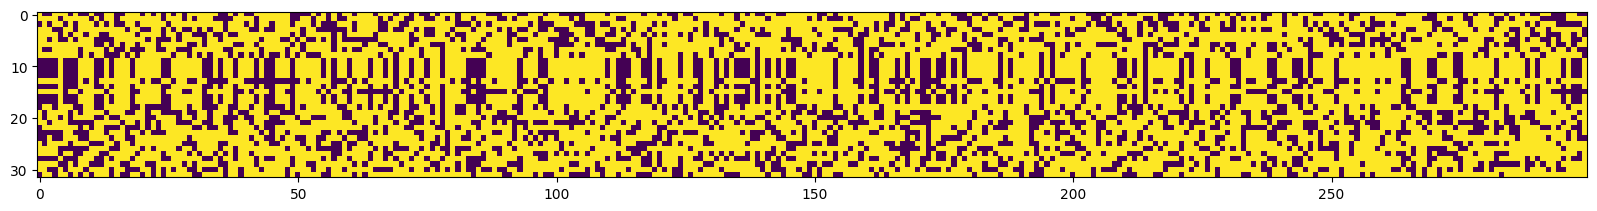

In [151]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > .5)
h[:3][:3]

(array([445., 381., 325., 296., 263., 193., 314., 198., 233., 139., 165.,
        171., 198., 165., 139., 127., 118., 115., 126., 163., 103., 134.,
        112., 109., 130., 140., 113.,  77., 111., 129., 129.,  97.,  96.,
        135., 132., 135., 155., 184., 143., 199., 153., 179., 244., 211.,
        326., 237., 279., 350., 337., 447.]),
 array([-9.99615550e-01, -9.59633321e-01, -9.19651091e-01, -8.79668862e-01,
        -8.39686632e-01, -7.99704403e-01, -7.59722173e-01, -7.19739944e-01,
        -6.79757714e-01, -6.39775485e-01, -5.99793255e-01, -5.59811026e-01,
        -5.19828796e-01, -4.79846567e-01, -4.39864337e-01, -3.99882108e-01,
        -3.59899879e-01, -3.19917649e-01, -2.79935420e-01, -2.39953190e-01,
        -1.99970961e-01, -1.59988731e-01, -1.20006502e-01, -8.00242722e-02,
        -4.00420427e-02, -5.98132610e-05,  3.99224162e-02,  7.99046457e-02,
         1.19886875e-01,  1.59869105e-01,  1.99851334e-01,  2.39833564e-01,
         2.79815793e-01,  3.19798023e-01,  3.59780

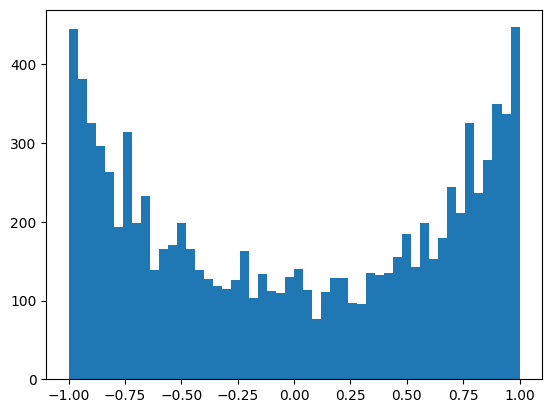

In [152]:
plt.hist(h.view(-1).tolist(), 50)

(array([6.000000e+00, 6.400000e+01, 2.327000e+03, 5.520000e+02,
        4.595000e+03, 6.679000e+03, 9.583000e+03, 1.600700e+04,
        2.152000e+04, 4.373000e+04, 1.448960e+05, 1.646220e+05,
        2.384590e+05, 4.197540e+05, 6.133270e+05, 8.921350e+05,
        1.279948e+06, 1.730361e+06, 2.139893e+06, 2.833377e+06,
        3.372200e+06, 3.657332e+06, 4.091973e+06, 4.176879e+06,
        4.513110e+06, 4.207633e+06, 4.129671e+06, 3.514405e+06,
        3.085125e+06, 2.378826e+06, 2.070364e+06, 1.530990e+06,
        1.131697e+06, 6.920600e+05, 5.947340e+05, 3.795500e+05,
        2.717470e+05, 1.358290e+05, 1.547230e+05, 6.918000e+04,
        4.281700e+04, 1.709500e+04, 4.171000e+03, 1.634000e+03,
        4.640000e+02, 1.099000e+03, 2.950000e+02, 5.500000e+01,
        4.000000e+00, 3.000000e+00]),
 array([-94.58927155, -90.68123474, -86.77319794, -82.86516113,
        -78.95712433, -75.04908752, -71.14105072, -67.23301392,
        -63.32497711, -59.41694031, -55.5089035 , -51.6008667 ,
  

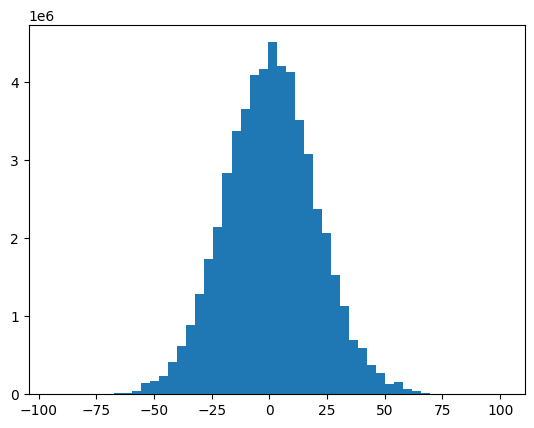

In [153]:
plt.hist(h_preactivation.view(-1).tolist(), 50)

(array([7.000e+00, 6.000e+00, 0.000e+00, 5.000e+00, 5.000e+00, 1.600e+01,
        9.000e+00, 3.000e+00, 1.300e+01, 8.000e+00, 2.800e+01, 2.400e+01,
        3.100e+01, 5.300e+01, 5.700e+01, 7.000e+01, 7.000e+01, 1.290e+02,
        1.870e+02, 1.950e+02, 3.200e+02, 5.450e+02, 1.389e+03, 2.586e+03,
        1.768e+03, 6.730e+02, 3.370e+02, 2.530e+02, 1.880e+02, 1.400e+02,
        9.500e+01, 7.800e+01, 5.400e+01, 5.300e+01, 3.100e+01, 2.600e+01,
        2.700e+01, 1.400e+01, 6.000e+00, 1.600e+01, 5.000e+00, 1.600e+01,
        1.000e+01, 2.200e+01, 7.000e+00, 1.000e+01, 1.000e+00, 1.000e+00,
        0.000e+00, 1.300e+01]),
 array([-10.29867172,  -9.86281076,  -9.42694981,  -8.99108885,
         -8.55522789,  -8.11936693,  -7.68350597,  -7.24764502,
         -6.81178406,  -6.3759231 ,  -5.94006214,  -5.50420118,
         -5.06834023,  -4.63247927,  -4.19661831,  -3.76075735,
         -3.32489639,  -2.88903543,  -2.45317448,  -2.01731352,
         -1.58145256,  -1.1455916 ,  -0.70973064,  -0.27

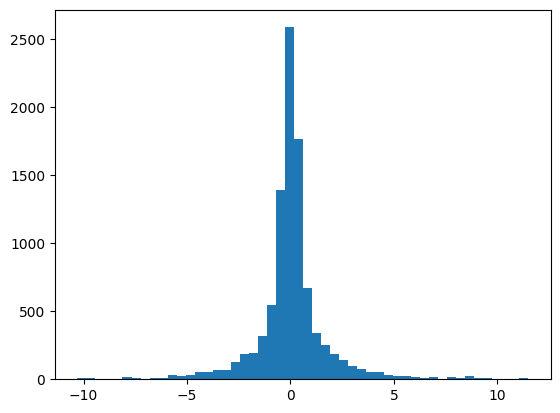

In [92]:
plt.hist(h_preactivation.view(-1).tolist(), 50)

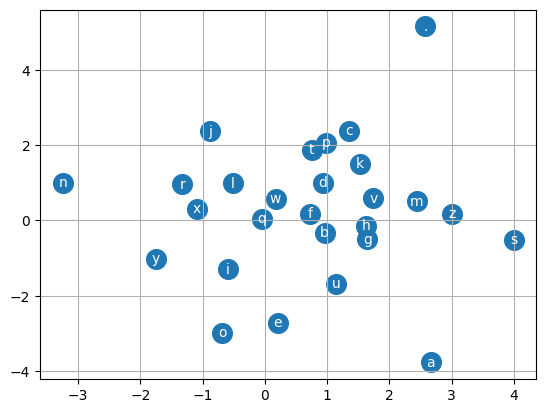

In [49]:
# Only works if embedding size = 2
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [181]:
h_neurons = 100
embedding_size = 10

class Linear:
    def __init__(self, fan_in: int, fan_out, bias: bool = True) -> None:
        self.weights: torch.Tensor = torch.randn((fan_in, fan_out), generator=g) / fan_in ** .5
        self.bias: torch.Tensor = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # learnable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers trained with a running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_variance = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_variance = self.running_var
        
        x_hat = (x-x_mean) / torch.sqrt(x_variance + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1- self.momentum) * self.running_var + self.momentum * x_variance
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return[]
    
C = torch.randn((V, embedding_size), generator=g)
layers: list = [
    Linear(embedding_size * block_size, h_neurons), Tanh(),
    Linear(h_neurons, h_neurons), BatchNorm1d(h_neurons), Tanh(),
    Linear(h_neurons, h_neurons), BatchNorm1d(h_neurons), Tanh(),
    Linear(h_neurons, h_neurons), BatchNorm1d(h_neurons), Tanh(),
    Linear(h_neurons, h_neurons), BatchNorm1d(h_neurons), Tanh(),
    Linear(h_neurons, V), 
]

with torch.no_grad():
    layers[-1].weights *= .1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
n_parameters = sum(p.nelement() for p in parameters)
print(f'{n_parameters=}')
for p in parameters:
    p.requires_grad = True

n_parameters=47297


In [199]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.03 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.7754


layer 1 (      Tanh): mean -0.04, std 0.77, saturated: 21.78%
layer 4 (      Tanh): mean -0.01, std 0.66, saturated: 4.31%
layer 7 (      Tanh): mean +0.01, std 0.67, saturated: 4.62%
layer 10 (      Tanh): mean +0.00, std 0.68, saturated: 3.88%
layer 13 (      Tanh): mean -0.01, std 0.67, saturated: 3.09%


Text(0.5, 1.0, 'activation distribution')

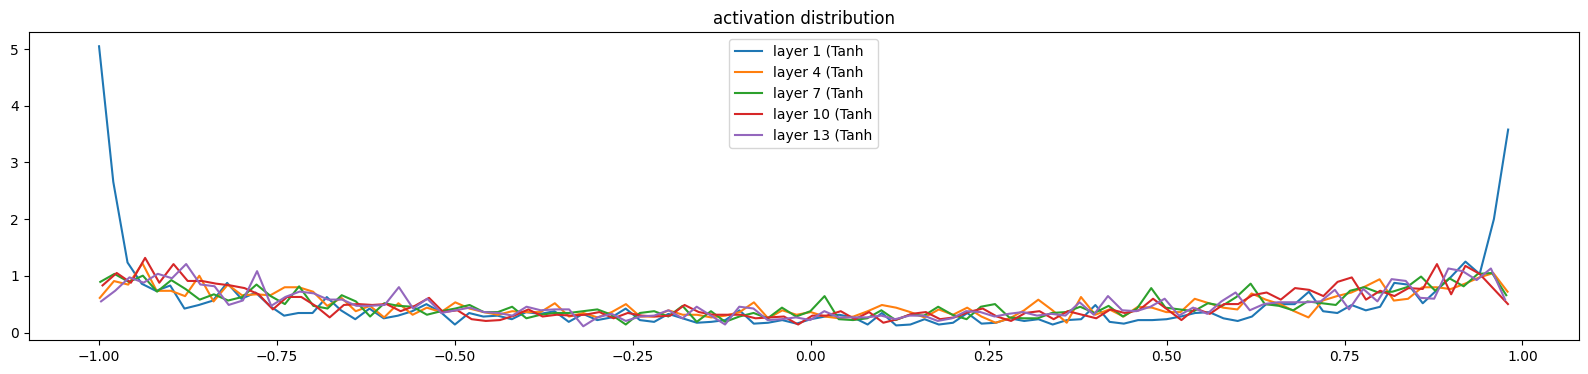

In [200]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000020, std 3.738585e-03
layer 4 (      Tanh): mean -0.000006, std 3.613653e-03
layer 7 (      Tanh): mean -0.000030, std 3.362725e-03
layer 10 (      Tanh): mean -0.000067, std 2.995199e-03
layer 13 (      Tanh): mean -0.000062, std 2.492714e-03


Text(0.5, 1.0, 'gradient distribution')

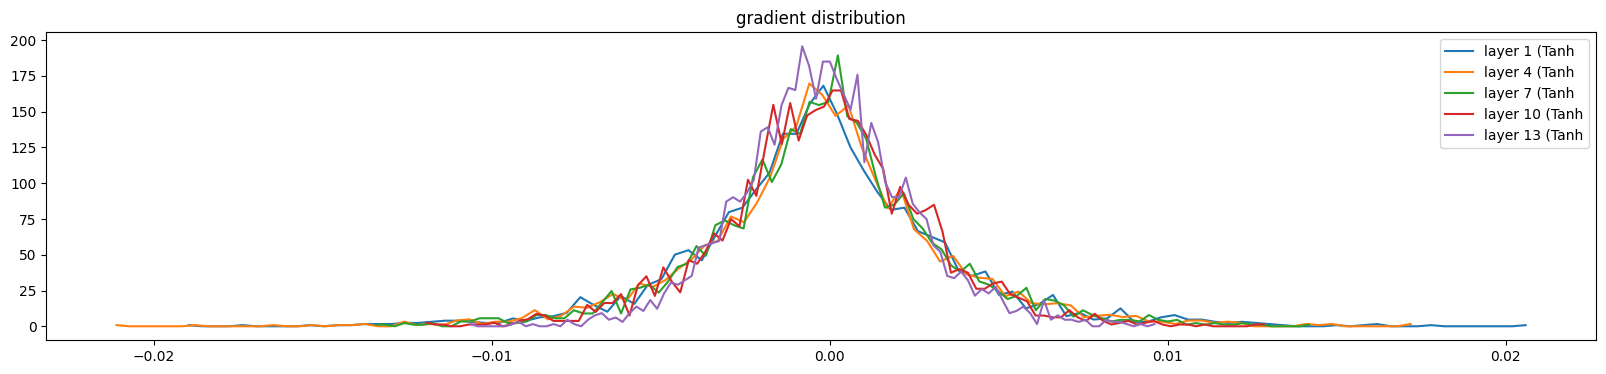

In [201]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000004 | std 1.135245e-02 | grad:data ratio 1.165915e-02
weight  (30, 100) | mean +0.000179 | std 1.108189e-02 | grad:data ratio 3.549080e-02
weight (100, 100) | mean -0.000121 | std 8.102787e-03 | grad:data ratio 4.753486e-02
weight (100, 100) | mean -0.000008 | std 6.810487e-03 | grad:data ratio 4.012419e-02
weight (100, 100) | mean -0.000027 | std 5.889702e-03 | grad:data ratio 3.489475e-02
weight (100, 100) | mean -0.000003 | std 4.979684e-03 | grad:data ratio 2.963553e-02
weight  (100, 27) | mean -0.000000 | std 2.051193e-02 | grad:data ratio 2.572640e-01


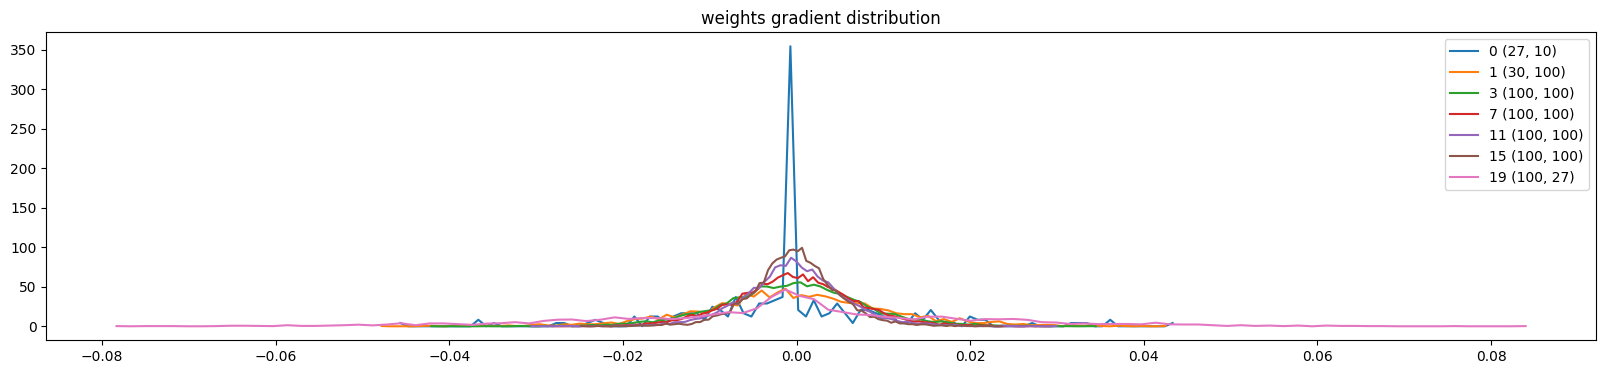

In [202]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

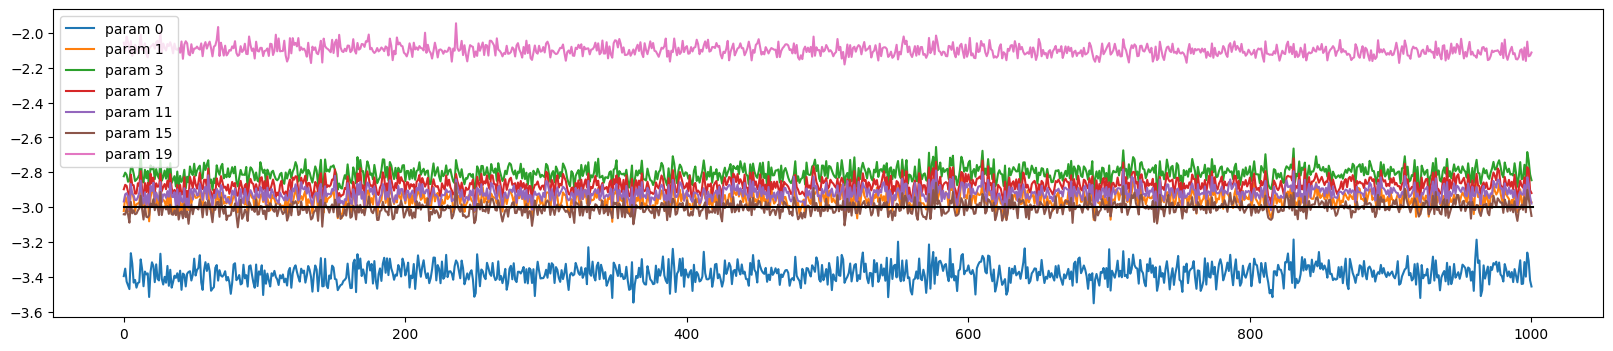

In [203]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [187]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_dev, y_dev),
    'test': (X_test, y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.377530097961426
val 2.371304512023926


In [188]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

careah.
qar.
hari.
kimlex.
thty.
halaysa.
jaronte.
dellahtiiaqei.
ner.
kis.
chaiiv.
kaleig.
dham.
poin.
qainu.
shoin.
arian.
qurqaelo.
dearyxix.
kae.


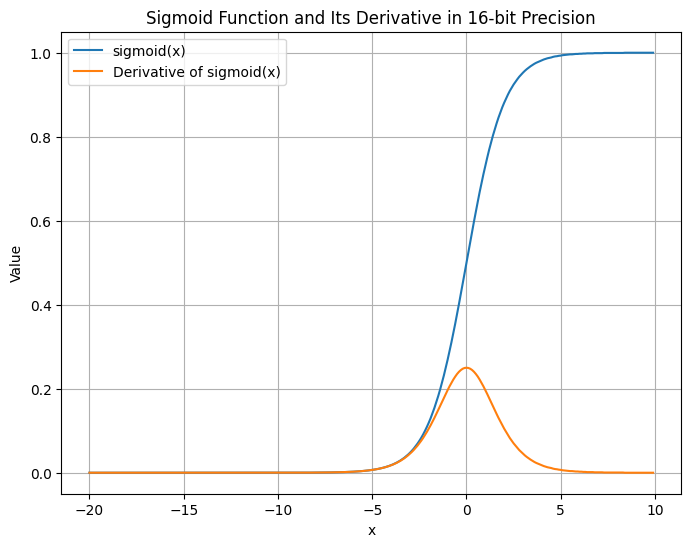

torch.Size([300])

In [226]:
import torch
import matplotlib.pyplot as plt

# Create a range of values in float32 for better range handling
base = torch.arange(-20, 10, 0.1, dtype=torch.float32)

# Convert to 16-bit (half) precision
base_half = base.half()

# Compute the sigmoid function in half precision
sigmoid_half = torch.sigmoid(base_half)

# Compute the derivative: σ(x) * (1 - σ(x))
derivative_half = sigmoid_half * (1 - sigmoid_half)

# Convert to float32 for plotting so that matplotlib handles them correctly
sigmoid_vals = sigmoid_half.float().numpy()
derivative_vals = derivative_half.float().numpy()

# Plotting the sigmoid and its derivative
plt.figure(figsize=(8, 6))
plt.plot(base.numpy(), sigmoid_vals, label="sigmoid(x)")
plt.plot(base.numpy(), derivative_vals, label="Derivative of sigmoid(x)")
plt.xlabel("x")
plt.ylabel("Value")
plt.title("Sigmoid Function and Its Derivative in 16-bit Precision")
plt.legend()
plt.grid(True)
plt.show()
derivative_half.shape